In [1]:
import berrylib.util as util
util.setup_nb()

In [2]:
from scipy.special import logit, expit
import matplotlib.pyplot as plt
import numpy as np
import pykevlar.grid as grid
import berrylib.fast_inla as fast_inla
import berrylib.binomial as binomial

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
fi = fast_inla.FastINLA(2)

name = 'berry2d'
n_arms = 2
n_arm_samples = 35
seed = 10
n_theta_1d = 16
sim_size = 10000

# define null hypos
null_hypos = []
for i in range(n_arms):
    n = np.zeros(n_arms)
    # null is:
    # theta_i <= logit(0.1)
    # the normal should point towards the negative direction. but that also
    # means we need to negate the logit(0.1) offset
    n[i] = -1
    null_hypos.append(grid.HyperPlane(n, -logit(0.1)))

gr = grid.make_cartesian_grid_range(n_theta_1d, np.full(n_arms, -3.5), np.full(n_arms, 1.0), sim_size)
gr.create_tiles(null_hypos)
gr.prune()

In [4]:
theta = gr.thetas().T
theta_tiles = grid.theta_tiles(gr)
is_null_per_arm = grid.is_null_per_arm(gr)

In [5]:
samples = np.random.uniform(size=(sim_size, n_arm_samples, n_arms))
accumulator = binomial.binomial_accumulator(fi.rejection_inference)
typeI_sum, typeI_score = accumulator(theta_tiles, is_null_per_arm, samples)

In [6]:
from pykevlar.model.binomial import SimpleSelection
sys.path.append('../../python/example')
import utils
delta = 0.025
simple_selection_model = SimpleSelection(fi.n_arms, n_arm_samples, 1, [])
simple_selection_model.critical_values([fi.critical_value])

In [7]:
from pykevlar.bound import TypeIErrorAccum
acc_o = TypeIErrorAccum(simple_selection_model.n_models(), gr.n_tiles(), gr.n_params())
typeI_sum = typeI_sum.astype(np.uint32).reshape((1, -1))
score_sum = typeI_score.flatten()
acc_o.pool_raw(typeI_sum, score_sum)
print(np.all(acc_o.typeI_sum() == typeI_sum))
print(np.all(acc_o.score_sum() == score_sum))

True
True


In [8]:
P, B = utils.create_ub_plot_inputs(simple_selection_model, acc_o, gr, delta)

0 76
corner -2.375
-2.375
-0.0882684
corner -2.19722
  -2.375
-0.0303859
corner   -2.375
-2.09375
-0.00330469
corner -2.19722
-2.09375
0.0545778
0 77
corner -2.19722
  -2.375
-0.0413136
corner -2.19722
-2.09375
0.053601
corner -2.09375
  -2.375
-0.0242016
corner -2.09375
-2.09375
0.070713
0 78
corner -2.375
-2.375
-0.0716053
corner -2.19722
  -2.375
-0.00831786
corner   -2.375
-2.09375
-0.0285187
corner -2.19722
-2.09375
0.0347687


In [9]:
import scipy.special

delta_prop_0to1 = 0.5
d0u_factor = 1.0 - delta * delta_prop_0to1
# monte carlo estimate of type I error at each theta.
delta_0_j = typeI_sum[0] / sim_size
# clopper-pearson upper bound in beta form.
delta_0_u_j = (
    scipy.stats.beta.ppf(d0u_factor, typeI_sum[0] + 1, sim_size - typeI_sum[0])
    - delta_0_j
)
np.testing.assert_allclose(delta_0_j, B[:, 0])
np.testing.assert_allclose(delta_0_u_j, B[:, 1])

In [10]:
corners = np.empty((gr.n_tiles(), 2**gr.n_params(), gr.n_params()))
for i in range(2**gr.n_params()):
    corners[:, i, :] = np.array(gr.corners(i))

In [28]:
n_tiles_per_pt = grid.n_tiles_per_pt(gr)
n_tiles_per_pt[74]

1

In [12]:
corners[76:79]

array([[[-2.375     , -2.375     ],
        [-2.19722458, -2.375     ],
        [-2.375     , -2.09375   ],
        [-2.19722458, -2.09375   ]],

       [[-2.19722458, -2.375     ],
        [-2.19722458, -2.09375   ],
        [-2.09375   , -2.375     ],
        [-2.09375   , -2.09375   ]],

       [[-2.375     , -2.375     ],
        [-2.19722458, -2.375     ],
        [-2.375     , -2.09375   ],
        [-2.19722458, -2.09375   ]]])

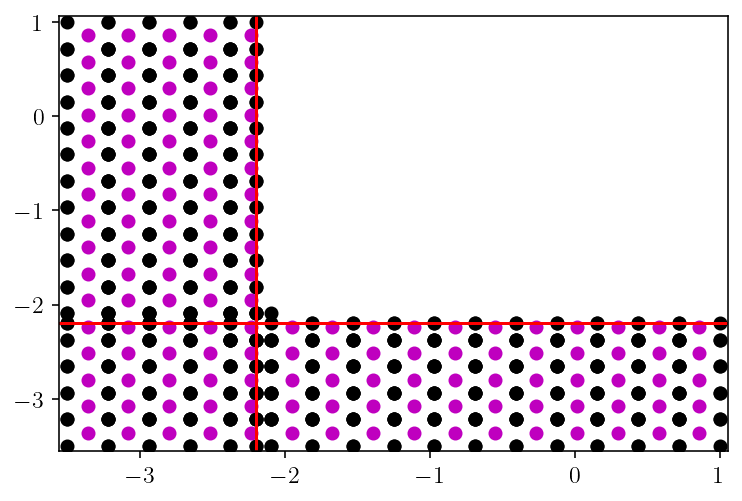

In [11]:
c_flat = corners.reshape((-1, 2))
plt.scatter(c_flat[:,0], c_flat[:,1], c='k')
plt.scatter(theta[:,0], theta[:,1], c='m')
plt.hlines(logit(0.1), -4, 2, 'r')
plt.vlines(logit(0.1), -4, 2, 'r')
plt.xlim(np.min(theta[:,0]) - 0.2, np.max(theta[:,0]) + 0.2)
plt.ylim(np.min(theta[:,1]) - 0.2, np.max(theta[:,1]) + 0.2)
plt.show()

In [13]:
from scipy.special import expit
p_tiles = expit(theta_tiles)
v_diff = corners - theta_tiles[:, None]
v_sq = v_diff ** 2

In [14]:
d1u_factor = np.sqrt(1 / ((1 - delta_prop_0to1) * delta) - 1.0)
covar_quadform = (n_arm_samples * v_sq * p_tiles[:, None] * (1 - p_tiles[:, None])).sum(axis=-1)
d1u = np.sqrt(covar_quadform) * (d1u_factor / np.sqrt(sim_size))
d1 = ((typeI_score.to_py() / sim_size)[:, None] * v_diff).sum(axis=-1)

In [15]:
(((typeI_score.to_py() / sim_size)[:, None]) * v_diff).sum(axis=-1)[79]

array([-0.09361595, -0.01896257, -0.02448959,  0.05016379])

In [16]:
radii = grid.radii_tiles(gr)
p_lower = np.tile(expit(theta_tiles - radii)[:, None], (1, 4, 1))
p_upper = np.tile(expit(theta_tiles + radii)[:, None], (1, 4, 1))

hess_comp = np.empty((theta_tiles.shape[0], 4, 2))
special = (p_lower <= 0.5) & (0.5 <= p_upper)
hess_comp[special] = 0.25 * v_sq[special]
max_p = np.where(np.abs(p_upper - 0.5) < np.abs(p_lower - 0.5), p_upper, p_lower)
hess_comp[~special] = (max_p * (1 - max_p) * v_sq)[~special]

hessian_quadform_bound = hess_comp.sum(axis=-1) * n_arm_samples
d2u = 0.5 * hessian_quadform_bound

In [18]:
# worst_corner = (d1u + d2u + d1).argmax(axis=1)
worst_corner = (d1).argmax(axis=1)
ti = np.arange(d1.shape[0])
d1w = d1[ti, worst_corner]
d1uw = d1u[ti, worst_corner]
d2uw = d2u[ti, worst_corner]

In [23]:
bad_d1[79:90]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

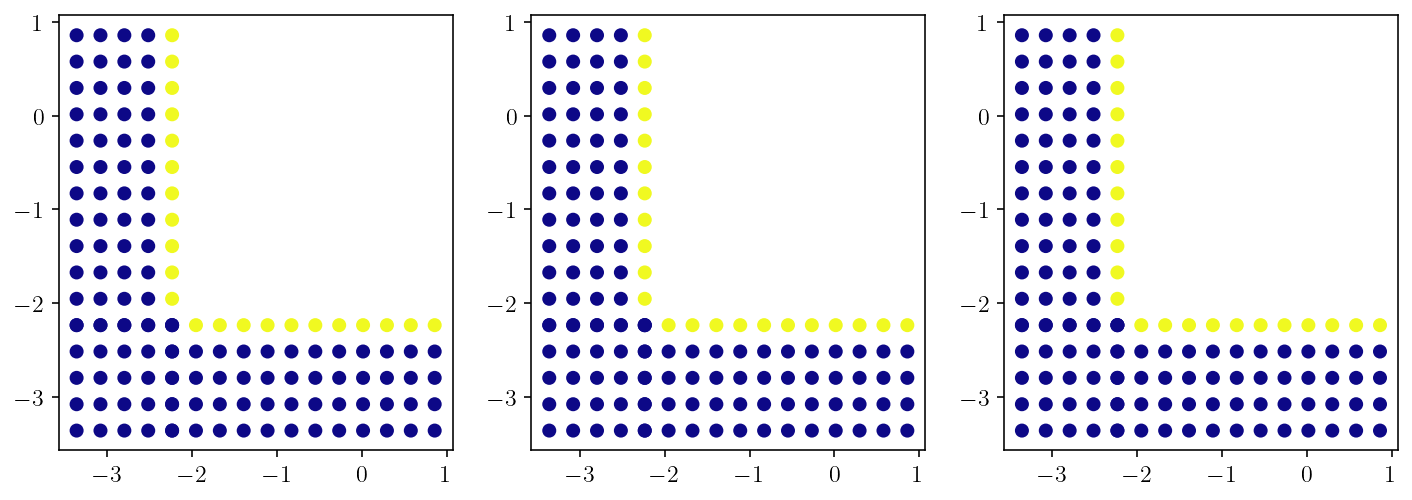

In [20]:
bad_d1 = np.abs(d1w - B[:,2]) > 1e-10
bad_d1u = np.abs(d1uw - B[:,3]) > 1e-10
bad_d2u = np.abs(d2uw - B[:,4]) > 1e-10
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=bad_d1)
plt.subplot(1,3,2)
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=bad_d1u)
plt.subplot(1,3,3)
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=bad_d2u)
plt.show()

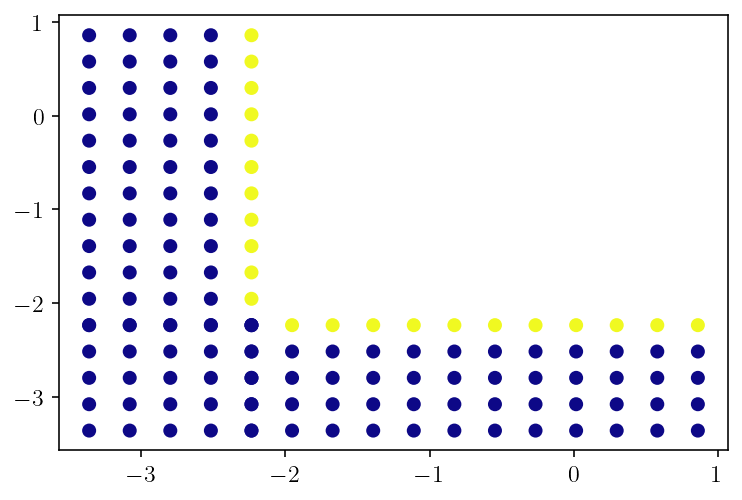

In [ ]:
bad = np.abs(d1w - B[:,2]) > 1e-10
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=bad)
plt.show()

In [19]:
np.testing.assert_allclose(d1w, B[:,2])
np.testing.assert_allclose(d1uw, B[:,3])
np.testing.assert_allclose(d2uw, B[:,4])

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 22 / 145 (15.2%)
Max absolute difference: 0.06763174
Max relative difference: 0.72025904
 x: array([0.000883, 0.002568, 0.00569 , 0.016496, 0.012064, 0.003101,
       0.005554, 0.010096, 0.01362 , 0.011678, 0.009601, 0.007588,
       0.00529 , 0.004177, 0.00419 , 0.003014, 0.002547, 0.00199 ,...
 y: array([0.000883, 0.002568, 0.00569 , 0.016496, 0.012064, 0.003101,
       0.005554, 0.010096, 0.01362 , 0.011678, 0.009601, 0.007588,
       0.00529 , 0.004177, 0.00419 , 0.003014, 0.002547, 0.00199 ,...

In [67]:
B[:,2]

array([ 0.00038311,  0.00123102,  0.00334746,  0.01277408, -0.03184838,
        0.00302271,  0.00527408,  0.0081362 ,  0.01055053,  0.00980325,
        0.01117275,  0.01040156,  0.00652791,  0.00472997,  0.00428624,
        0.00389265,  0.00342781,  0.00136955,  0.00213247,  0.00418039,
        0.01362971, -0.03117773,  0.00713559,  0.01176727,  0.01828729,
        0.02344588,  0.02132319,  0.02341349,  0.02198624,  0.01467686,
        0.01055717,  0.01077307,  0.01074029,  0.00992466,  0.00498627,
        0.00556398,  0.00845167,  0.01846468, -0.0257446 ,  0.01572214,
        0.02547423,  0.03642204,  0.04465475,  0.03961343,  0.04671283,
        0.0421844 ,  0.03092742,  0.02409948,  0.02424817,  0.02421008,
        0.02260829,  0.01495456,  0.01429516,  0.01867878,  0.03031309,
        0.02855479,  0.03389308,  0.05228244,  0.07060953,  0.08108652,
        0.06915194,  0.08106541,  0.0762133 ,  0.06001219,  0.0500314 ,
        0.05004052,  0.05038423,  0.04858078,  0.01150164,  0.00

In [18]:

utils.save_ub(f"P-{name}-{n_theta_1d}-{sim_size}.csv", f"B-{name}-{n_theta_1d}-{sim_size}.csv", P, B)

In [34]:
for i in [4,5]:
    print(corners[i] - theta_tiles[i])

[[-0.140625   -0.140625  ]
 [-0.03715042 -0.140625  ]
 [-0.140625    0.140625  ]
 [-0.03715042  0.140625  ]]
[[-0.03715042 -0.140625  ]
 [-0.03715042  0.140625  ]
 [ 0.140625   -0.140625  ]
 [ 0.140625    0.140625  ]]


In [29]:
i = 4
corners[i], corners[i+1]

(array([[-2.375     , -3.5       ],
        [-2.27152542, -3.5       ],
        [-2.375     , -3.21875   ],
        [-2.27152542, -3.21875   ]]),
 array([[-2.27152542, -3.5       ],
        [-2.27152542, -3.21875   ],
        [-2.09375   , -3.5       ],
        [-2.09375   , -3.21875   ]]))

In [36]:
logit(0.1) - 2 * 0.03715042

-2.271525417336219

In [22]:
n_tiles_per_pt[4]

2

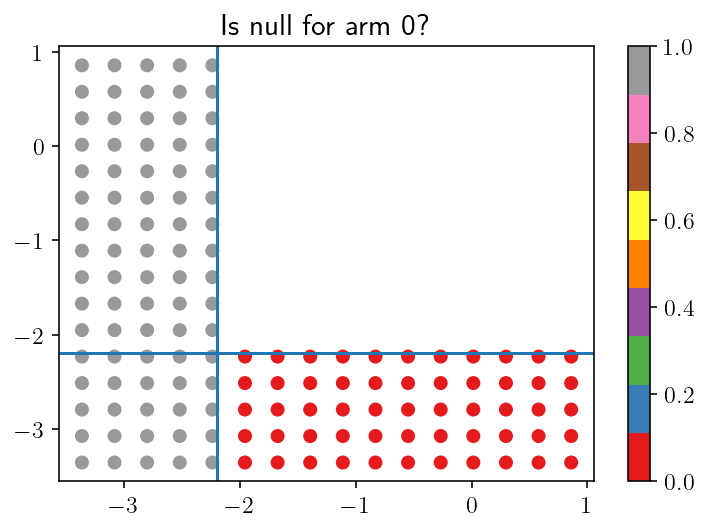

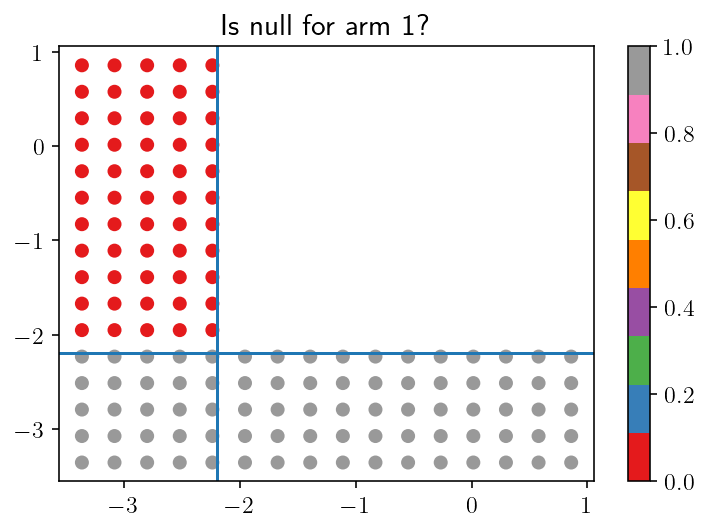

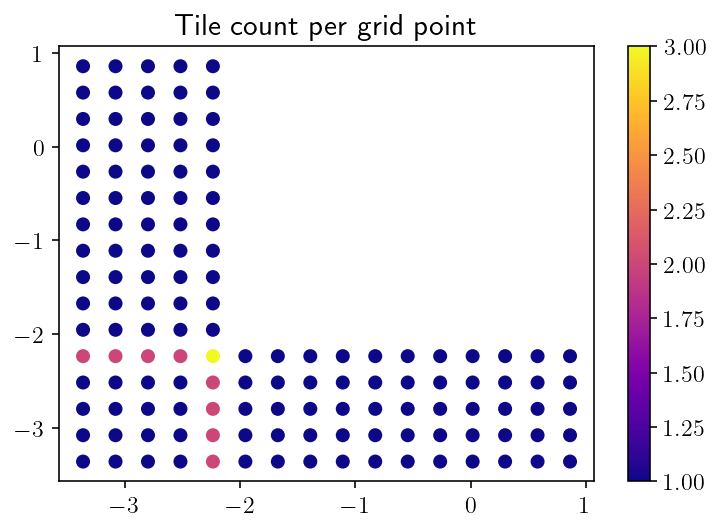

In [19]:
n_tiles_per_pt = grid.n_tiles_per_pt(gr)
pos_start = gr.cum_n_tiles()[:-1]
is_null_per_arm_gridpt = np.add.reduceat(is_null_per_arm, pos_start, axis=0) > 0

plt.title('Is null for arm 0?')
plt.scatter(theta[:,0], theta[:,1], c=is_null_per_arm_gridpt[:,0], cmap='Set1')
plt.hlines(logit(0.1), -4, 2)
plt.vlines(logit(0.1), -4, 2)
plt.xlim(np.min(theta[:,0]) - 0.2, np.max(theta[:,0]) + 0.2)
plt.ylim(np.min(theta[:,1]) - 0.2, np.max(theta[:,1]) + 0.2)
plt.colorbar()
plt.show()

plt.title('Is null for arm 1?')
plt.scatter(theta[:,0], theta[:,1], c=is_null_per_arm_gridpt[:,1], cmap='Set1')
plt.hlines(logit(0.1), -4, 2)
plt.vlines(logit(0.1), -4, 2)
plt.xlim(np.min(theta[:,0]) - 0.2, np.max(theta[:,0]) + 0.2)
plt.ylim(np.min(theta[:,1]) - 0.2, np.max(theta[:,1]) + 0.2)
plt.colorbar()
plt.show()

plt.title('Tile count per grid point')
plt.scatter(theta[:,0], theta[:,1], c=n_tiles_per_pt)
plt.colorbar()
plt.show()

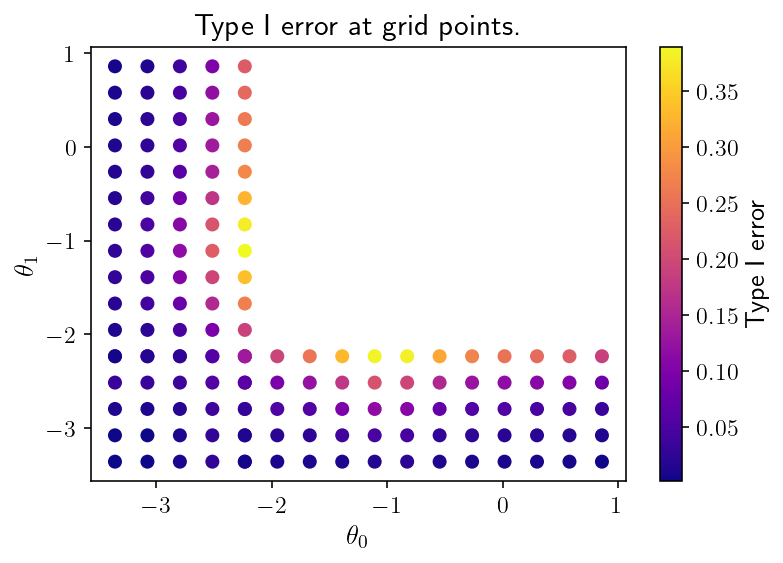

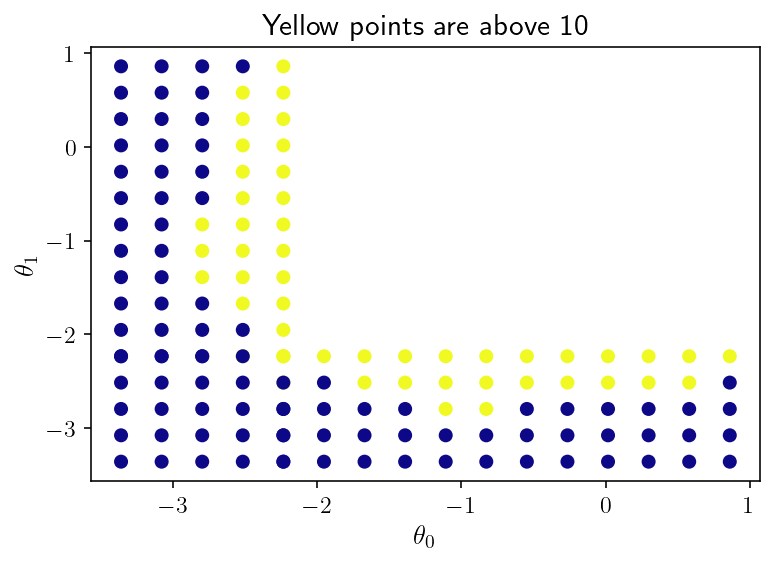

In [9]:
plt.figure()
plt.title('Type I error at grid points.')
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=typeI_sum / sim_size)
cbar = plt.colorbar()
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Type I error')
plt.show()
plt.title('Yellow points are above 10%')
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=typeI_sum / sim_size > 0.1)
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.show()

# Comparing against MCMC for a few grid points

This is a check to determine how much of the type I error is real versus an artifact coming from INLA.



In [10]:
import berrylib.mcmc as mcmc

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
sorted_idxs = np.argsort(typeI_sum)
idx = sorted_idxs[-1]
theta_tiles[idx]

array([-2.234375, -0.828125])

In [14]:
# y_mcmc = y[idx, :]
# n_mcmc = np.full((sim_size, n_arms), n_arm_samples)
# data_mcmc = np.stack((y_mcmc, n_mcmc), axis=-1)
# n_mcmc_sims = 1000
# results_mcmc = mcmc.mcmc_berry(
#     data_mcmc[:n_mcmc_sims], fi.logit_p1, np.full(n_mcmc_sims, fi.thresh_theta), n_arms=2
# )
# success_mcmc = results_mcmc["exceedance"] > critical_values[0]

In [15]:
import pickle
load = True
if load: 
    with open(f'berry_kevlar_mcmc{idx}.pkl', 'rb') as f:
        results_mcmc = pickle.load(f)
else:
    with open(f'berry_kevlar_mcmc{idx}.pkl', 'wb') as f:
        pickle.dump(results_mcmc, f)

FileNotFoundError: [Errno 2] No such file or directory: 'berry_kevlar_mcmc114.pkl'

In [20]:
mcmc_typeI = np.sum(np.any(success_mcmc & is_null_per_arm[idx, None,:], axis=-1), axis=-1)
inla_typeI = typeI_sum[idx]
mcmc_typeI, inla_typeI

(335, 388)

In [ ]:
bad_sim_idxs = np.where(
    np.any((success[idx] & (~success_mcmc)) & is_null_per_arm[idx, None], axis=-1)
)[0]
unique_bad = np.unique(y[idx, bad_sim_idxs], axis=0)
print("theta =", theta_tiles[idx])
bad_count = 0
for i in range(unique_bad.shape[0]):
    y_bad = unique_bad[i]
    other_sim_idx = np.where((y[idx, :, 0] == y_bad[0]) & (y[idx, :, 1] == y_bad[1]))[0]
    pct_mcmc = (
        np.any(
            success_mcmc[other_sim_idx] & is_null_per_arm[idx, None, :], axis=-1
        ).sum()
        / other_sim_idx.shape[0]
    )
    if pct_mcmc < 0.2:
        print("bad y =", y_bad, "count =", other_sim_idx.shape[0])
        bad_count += other_sim_idx.shape[0]
print("\ninla type I =", inla_typeI)
print("bad type I count =", bad_count)
print('"true" type I count =', inla_typeI - bad_count)
# print('pct of mcmc sims that had type I error', pct_mcmc)
# print('')

# print(
#     "unique y where INLA says type 1 but MCMC says not type 1: ",
#     np.unique(y[idx, bad_sim_idxs], axis=0),
# )


In [ ]:
bad_sim_idxs = np.where(np.any((success[idx] & (success_mcmc)) & is_null_per_arm[idx, None], axis=-1))[0]
print('theta: ', theta_tiles[idx])
print('unique y where INLA says type 1 and MCMC also says type 1: ', np.unique(y[idx, bad_sim_idxs], axis=0))

In [ ]:

bad_sim_idxs = np.where(np.any((~success[idx] & (~success_mcmc)) & is_null_per_arm[idx, None], axis=-1))[0]
print('theta: ', theta_tiles[idx])
print('unique y where INLA says type 1 and MCMC also says type 1: ', np.unique(y[idx, bad_sim_idxs], axis=0))

# Building a rejection table

In [11]:
%%time
rejection_table = binomial.build_rejection_table(n_arms, n_arm_samples, fi.rejection_inference)
np.random.seed(10)
typeI_sum = np.zeros(theta_tiles.shape[0])
typeI_score = np.zeros(theta_tiles.shape)
accumulator = binomial.binomial_accumulator(lambda y,n: binomial.lookup_rejection(rejection_table, y))
for i in range(sim_size):
    samples = np.random.uniform(0, 1, size=(1, n_arm_samples, fi.n_arms))
    chunk_typeI_sum, chunk_typeI_score = accumulator(theta_tiles, is_null_per_arm, samples)
    typeI_sum += chunk_typeI_sum
    typeI_score += chunk_typeI_score

CPU times: user 134 ms, sys: 4.2 ms, total: 138 ms
Wall time: 138 ms


In [12]:
typeI_sum.shape, theta_tiles.shape

((145,), (145, 2))

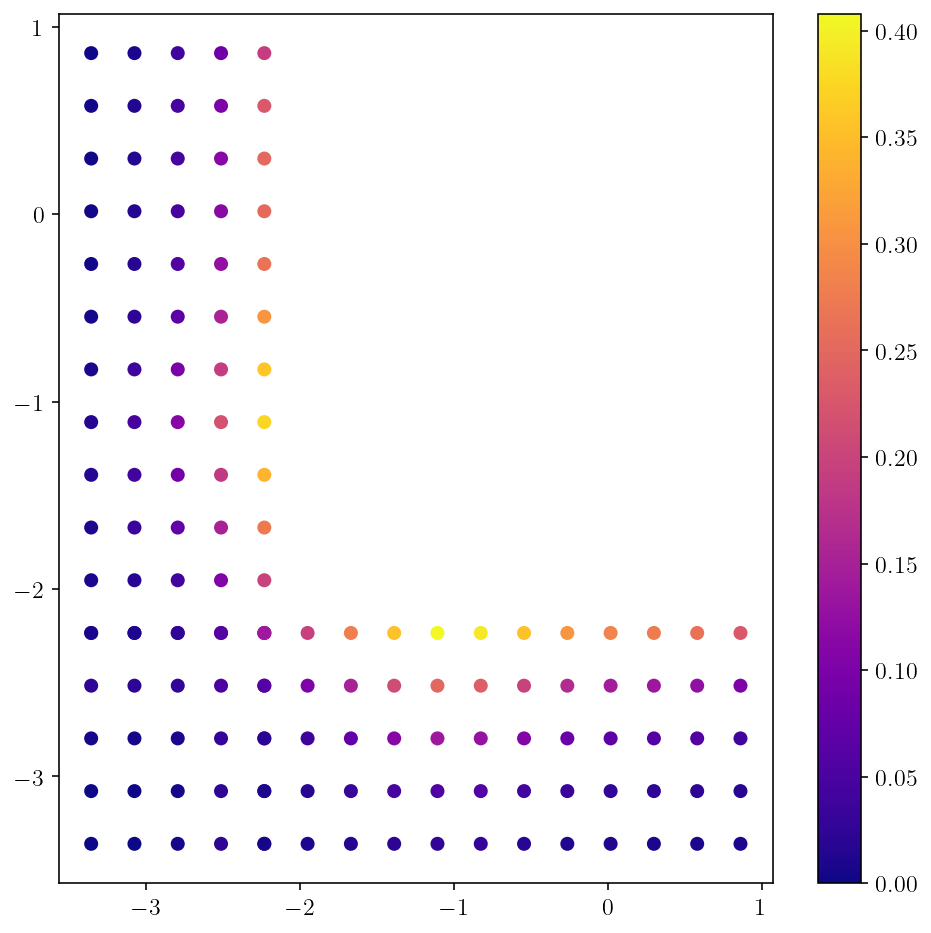

In [14]:
plt.figure(figsize=(8,8))
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=typeI_sum/sim_size)
plt.colorbar()
plt.show()

# Running a 4D grid

In [3]:
import berrylib.util as util
util.setup_nb()

# NOTE: don't be surprised if this JAX code does not scale linearly.
# JAX already uses parallelism within a single CPU device, so using multiple CPU
# devices will only take advantage of the remaining unused cores. In addition,
# there will be thrashing between the different threads trying to claim the same
# cores. This could be fixed by CPU pinning the JAX threads. There might be more
# potential to do this with a multiprocessing-based version of this
# parallelization. However, I didn't do this at the moment because I'm working
# on Mac where there is are no easy tools for CPU pinning threads. In addition, for
# higher performance, we should really be running this on a GPU where the effort
# of setting up tools for CPU pinning will have been wasted.
# see: https://github.com/google/jax/issues/743
# some other links that might be useful for parallel and multiprocessing JAX:
# - this link provides a path to cpu pinning on mac: http://www.hybridkernel.com/2015/01/18/binding_threads_to_cores_osx.html
# - more info on JAX multithreading: https://github.com/google/jax/issues/1539
# - running JAX inside multiprocessing: https://github.com/google/jax/issues/1805
n_requested_cores = 8
import os
os.environ["XLA_FLAGS"] = (
    f"--xla_force_host_platform_device_count={n_requested_cores} "
    "--xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1"
)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
from scipy.special import logit, expit
import matplotlib.pyplot as plt
import numpy as np
from pykevlar import mt19937
import pykevlar.grid as grid
from pykevlar.driver import accumulate_process
import pykevlar.core.model.binomial
import berrylib.binomial as binomial

import berrylib.fast_inla as fast_inla

name = 'berry2'
fi = fast_inla.FastINLA(4)
seed = 10
n_arm_samples = 35
n_theta_1d = 10
sim_size = 10000

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
loaded = np.load(f"{name}_{n_theta_1d}_{sim_size}.npy", allow_pickle=True).tolist()
gr = loaded['gr']
typeI_sum = loaded["sum"]
typeI_score = loaded["score"]
table = loaded["table"]
theta_tiles = loaded["theta_tiles"]
is_null_per_arm = loaded["is_null_per_arm"]

FileNotFoundError: [Errno 2] No such file or directory: 'berry2_10_10000.npy'

In [5]:
%%time
# define null hypos
null_hypos = []
for i in range(fi.n_arms):
    n = np.zeros(fi.n_arms)
    # null is:
    # theta_i <= logit(0.1)
    # the normal should point towards the negative direction. but that also
    # means we need to negate the logit(0.1) offset
    n[i] = -1
    null_hypos.append(grid.HyperPlane(n, -logit(0.1)))

gr = grid.make_cartesian_grid_range(n_theta_1d, np.full(fi.n_arms, -3.5), np.full(fi.n_arms, 1.0), sim_size)
gr.create_tiles(null_hypos)
gr.prune()
theta_tiles = grid.theta_tiles(gr)
is_null_per_arm = grid.is_null_per_arm(gr)

CPU times: user 1.17 s, sys: 6.64 ms, total: 1.18 s
Wall time: 1.17 s


In [6]:
%%time
table = binomial.build_rejection_table(fi.n_arms, n_arm_samples, fi.rejection_inference)

CPU times: user 4.29 s, sys: 235 ms, total: 4.52 s
Wall time: 3.38 s


# Parallel Jax accumulation

In [7]:
import time
import jax
import jax.numpy as jnp

reject_fnc = lambda y, n: binomial.lookup_rejection(table, y, n)
accum = binomial.binomial_accumulator(reject_fnc)
paccum = jax.pmap(accum, in_axes=(None, None, 0), out_axes=(0, 0), axis_name='i')

In [8]:
%%time
np.random.seed(seed)
typeI_sum = np.zeros(theta_tiles.shape[0], dtype=np.uint32)
typeI_score = np.zeros(theta_tiles.shape)
n_cores = jax.local_device_count()
for i in range(int(np.ceil(sim_size / n_cores))):
    chunk_size = np.minimum(n_cores, sim_size - i * n_cores)
    samples = np.random.uniform(0, 1, size=(chunk_size, 1, n_arm_samples, fi.n_arms))
    s, c = paccum(theta_tiles, is_null_per_arm, samples)
    typeI_sum += s.sum(axis=0)
    typeI_score += c.sum(axis=0)

CPU times: user 19.2 s, sys: 10.7 s, total: 29.9 s
Wall time: 4.74 s


In [9]:
i * n_cores, sim_size

(9992, 10000)

In [11]:
# If you kill the simulation early, run these lines to accept the smaller sim_size
# sim_size = (i + 1) * n_cores
# gr.sim_sizes()[:] = sim_size

In [10]:
np.save(
    f"{name}_{n_theta_1d}_{sim_size}.npy",
    dict(
        sum=typeI_sum,
        score=typeI_score,
        gr=gr,
        table=table,
        theta_tiles=theta_tiles,
        is_null_per_arm=is_null_per_arm,
    ),
    allow_pickle=True,
)


# Making some figures!

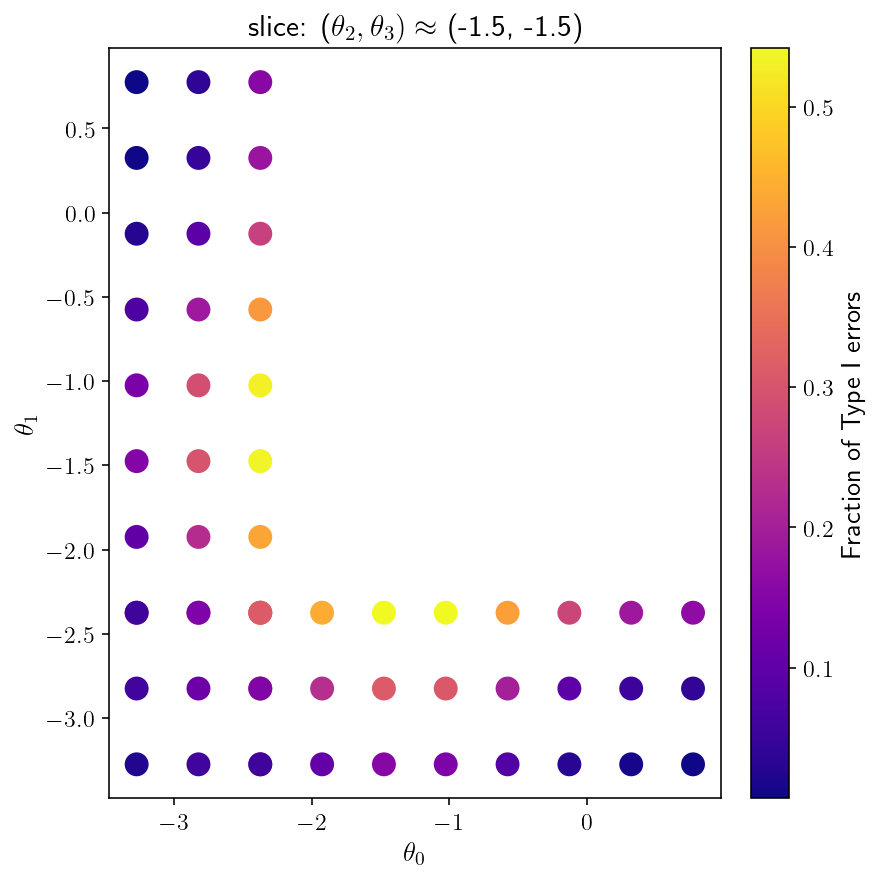

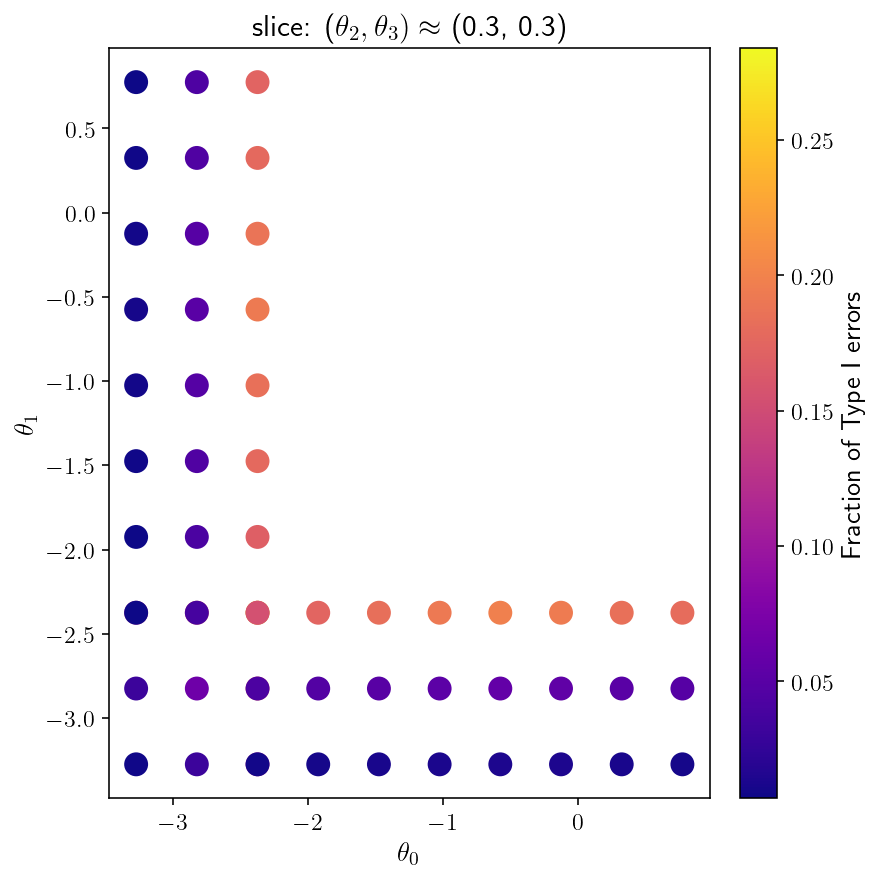

In [12]:
# for t2_idx, t3_idx in [(16, 16), (8, 8)]:
for t2_idx, t3_idx in [(4, 4), (8, 8)]:
    t2 = np.unique(theta_tiles[:, 2])[t2_idx]
    t3 = np.unique(theta_tiles[:, 2])[t3_idx]
    selection = (theta_tiles[:,2] == t2) & (theta_tiles[:,3] == t3)

    plt.figure(figsize=(6,6), constrained_layout=True)
    plt.title(f'slice: ($\\theta_2, \\theta_3) \\approx$ ({t2:.1f}, {t3:.1f})')
    plt.scatter(theta_tiles[selection,0], theta_tiles[selection,1], c=typeI_sum[selection]/sim_size, s=120)
    cbar = plt.colorbar()
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    cbar.set_label('Fraction of Type I errors')
    plt.savefig(f'grid_type1_{t2_idx}_{t3_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Compute the bound and save slices for the Plotly frontend

In [13]:
from pykevlar.model.binomial import SimpleSelection
sys.path.append('../../python/example')
import utils
delta = 0.025
simple_selection_model = SimpleSelection(fi.n_arms, n_arm_samples, 1, [])
simple_selection_model.critical_values([fi.critical_value])

In [14]:
from pykevlar.bound import TypeIErrorAccum
acc_o = TypeIErrorAccum(simple_selection_model.n_models(), gr.n_tiles(), gr.n_params())
typeI_sum = typeI_sum.astype(np.uint32).reshape((1, -1))
score_sum = typeI_score.flatten()
acc_o.pool_raw(typeI_sum, score_sum)
print(np.all(acc_o.typeI_sum() == typeI_sum))
print(np.all(acc_o.score_sum() == score_sum))

True
True


In [15]:
P, B = utils.create_ub_plot_inputs(simple_selection_model, acc_o, gr, delta)

In [ ]:
np.save(
    f"{name}_{n_theta_1d}_{sim_size}.npy",
    dict(
        P=P,
        B=B,
        sum=typeI_sum,
        score=typeI_score,
        gr=gr,
        table=table,
        theta_tiles=theta_tiles,
        is_null_per_arm=is_null_per_arm,
    ),
    allow_pickle=True,
)

In [29]:

for t2_idx, t3_idx in [(40, 40), (32, 32), (24, 24), (16, 16), (8, 8)]:
    t2 = np.unique(theta_tiles[:, 2])[t2_idx]
    t3 = np.unique(theta_tiles[:, 2])[t3_idx]
    selection = (theta_tiles[:,2] == t2) & (theta_tiles[:,3] == t3)
    Pselect = P[:, selection]
    Bselect = B[selection, :]
    utils.save_ub(f"P-{name}-{n_theta_1d}-{sim_size}-{t2_idx}.csv", f"B-{name}-{n_theta_1d}-{sim_size}-{t3_idx}.csv", Pselect, Bselect)

In [3]:
import numpy as np
data = np.load('berry2_64_8160.npy', allow_pickle=True)

In [9]:
data = data.tolist()

In [10]:
p_path = 'P4D.csv'
b_path = 'B4D.csv'
np.savetxt(p_path, data['P'], fmt="%s", delimiter=",")
np.savetxt(b_path, data['B'], fmt="%s", delimiter=",")

In [12]:
t3 = np.unique(data['theta_tiles'][:, 2])[8]
selection = (data['theta_tiles'][:,3] == t3)
p_path = 'P3D.csv'
b_path = 'B3D.csv'
np.savetxt(p_path, data['P'][:, selection], fmt="%s", delimiter=",")
np.savetxt(b_path, data['B'][selection, :], fmt="%s", delimiter=",")